# Transformer Based Model

# Imports

In [1]:
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from transformers import AutoTokenizer,MarianMTModel, MarianTokenizer,MBartForConditionalGeneration, MBart50TokenizerFast

from torch.utils.data import DataLoader, Dataset
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from collections import Counter

import os
import langid
import numpy as np
from langid.langid import LanguageIdentifier, model
import nltk
import torch
import math
import pandas as pd
import re

from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

state=42


if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available! Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available! Using CPU.")

CUDA is available! Using GPU.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hedir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hedir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hedir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Download data

In [2]:
translation_dataset_pd = load_dataset("Nicolas-BZRD/Parallel_Global_Voices_English_French",
                                      split="train",).to_pandas()
print(translation_dataset_pd.shape)
translation_dataset_pd.head(10)

(342060, 2)


,en,fr
0,Jamaica: “I am HIV”,Jamaïque : J’ai le VIH
1,"It's widely acknowledged, in the Caribbean and...","Il est largement reconnu, dans les Caraïbes et..."
2,"For this woman, however, photographed in the s...","Pour cette femme, cependant, photographiée dan..."
3,As Bacon writes on her blog:,Comme Bacon écrit sur son blog:
4,"“When I asked to take her picture, I suggested...",“Quand je lui ai demandé de la prendre en phot...
5,"“Nah man,” she replied.","” Nah man,” elle a répondu."
6,“P'haps udda people learn from my mistakes.”,“P'etre que des personnes apprendront de mes e...
7,"When I showed her the picture, she smiled sadl...","Quand je lui ai montré la photo, elle a souri ..."
8,"[Boy, that's an ugly face!]” The Caribbean is ...",La Caraïbe vient en seconde position seulement...
9,"At the end of 2005 it was estimated that 25,00...",À la fin de 2005 on a estimé que 25.000 person...


## Open file npy data

In [3]:
translation_dataset_np=np.load(os.getcwd()+"/Parallel_Global_Voices_English_French.npy",allow_pickle=True)
translation_dataset_pd=pd.DataFrame(translation_dataset_np,columns=["en","fr"])

In [3]:
print(translation_dataset_pd.shape)
translation_dataset_pd.head(10)

(342060, 2)


,en,fr
0,Jamaica: “I am HIV”,Jamaïque : J’ai le VIH
1,"It's widely acknowledged, in the Caribbean and...","Il est largement reconnu, dans les Caraïbes et..."
2,"For this woman, however, photographed in the s...","Pour cette femme, cependant, photographiée dan..."
3,As Bacon writes on her blog:,Comme Bacon écrit sur son blog:
4,"“When I asked to take her picture, I suggested...",“Quand je lui ai demandé de la prendre en phot...
5,"“Nah man,” she replied.","” Nah man,” elle a répondu."
6,“P'haps udda people learn from my mistakes.”,“P'etre que des personnes apprendront de mes e...
7,"When I showed her the picture, she smiled sadl...","Quand je lui ai montré la photo, elle a souri ..."
8,"[Boy, that's an ugly face!]” The Caribbean is ...",La Caraïbe vient en seconde position seulement...
9,"At the end of 2005 it was estimated that 25,00...",À la fin de 2005 on a estimé que 25.000 person...


In [2]:
def clean_data(file_name,dataset,threshold):
    array_meteor_score=np.load(file_name,allow_pickle=True)
    excluded_id=[]
    for i in range(len(array_meteor_score)):
        if array_meteor_score[i]<threshold:
            excluded_id.append(i)
    excluded_id=np.array(excluded_id)
    
    print(f"Number of wrong sentences : {len(excluded_id)}")

    for i in excluded_id[:5]:
        print("english : "+translation_dataset_np[i][0])
        print("french : "+translation_dataset_np[i][1])
    
    filtered_data = np.array([value for index, value in enumerate(dataset) if index not in excluded_id])
    wrong_sentences = np.array([value for index, value in enumerate(dataset) if index in excluded_id])

    print(len(filtered_data))
    
    sentences_with_links = np.array([sentence for sentence in filtered_data if contains_link(sentence[0]) and contains_link(sentence[1])])
    filtered_data = np.array([sentence for sentence in filtered_data if not contains_link(sentence[0]) and not contains_link(sentence[1])])

    print(len(filtered_data))
    
    filtered_data=clean_array_of_sentences(filtered_data)

    return filtered_data,wrong_sentences,sentences_with_links

def contains_link(sentence):
    return bool(re.search(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', sentence))

def clean_sentence(text):
    # Retire les espaces superflus
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def clean_array_of_sentences(sentences):
    cleaned_sentences = []
    for sentence in sentences:
        cleaned_eng = clean_sentence(sentence[0])
        cleaned_fr = clean_sentence(sentence[1])
        cleaned_sentences.append([cleaned_eng,cleaned_fr])
    
    return np.array(cleaned_sentences)

def replace_errors(sentence, error_dict):
    for error, correction in error_dict.items():
        sentence = sentence.replace(error, correction)
    return sentence

In [4]:
cleaned_data,wrong_sentences,sentences_with_links=clean_data(os.getcwd()+"/array_meteor_score.npy",translation_dataset_np,0.15)

Number of wrong sentences : 11605
english : In his profile Karim wrote that he was looking forward to helping humanity against all forms of discriminations.
french : Ne suivez donc pas les passions, afin de ne pas dévier de la justice.
english : The Qur'an implores believers to speak up against injustice, which is precisely what Karim has done.
french : Si vous portez un faux témoignage ou si vous le refusez, [sachez que] Dieu est Parfaitement Connaisseur de ce que vous faites ». Amira Al Hussaini
english : A description of the hurried legal procedure is pointed out here:
french : Un exemple d'expulsion « express » est relaté dans ce billet
english : she believes that:
french : Elle conclut par ces mots:
english : Sudanese Thinker had an interesting post entitled “Sudan: Arab or African?”
french : Sudanese Thinker pense que le Soudan est un pays Afro-Arabe :
330455
329434


In [16]:
print(sentences_with_links)

[["-Thanks to a commentary we remembered that Rafael Méndez leads a newspaper that keeps us up to date on what's happening in Naranjal: http://lanoticianaranjal.blogspot.com -Guillermo Granja, a popular Ecuadorean photographer and now owner of Agencia, wrote to us with his blog: http://guillermo.fotografosecuador.com"
  "Grâce à un commentaire, nous nous sommes souvenu que Rafael Méndez dirige un journal qui nous tient au courant de ce qui se passe à Naranjal: http://lanoticianaranjal.blogspot.com Guillermo Granja, un photographe équatorien célèbre, désormais propriétaire de L' Agencia, nous a écrit pour nous communiquer l'adresse de son blog: http://guillermo.fotografosecuador.com"]
 ['Now someone has created another CBox ie. http://burmanews.cbox.ws/ to translate all those messages from Niknayman Cbox in english for international outlookers.'
  "Quelqu'un vient de créer un nouveau compte Cbox. http://burmanews.cbox.ws/ pour traduire tous les messages de la Cbox de Niknayman en anglai

In [6]:
print(wrong_sentences)

[['In his profile Karim wrote that he was looking forward to helping humanity against all forms of discriminations.'
  'Ne suivez donc pas les passions, afin de ne pas dévier de la justice.']
 ["The Qur'an implores believers to speak up against injustice, which is precisely what Karim has done."
  'Si vous portez un faux témoignage ou si vous le refusez, [sachez que] Dieu est Parfaitement Connaisseur de ce que vous faites ». Amira Al Hussaini']
 ['A description of the hurried legal procedure is pointed out here:'
  "Un exemple d'expulsion « express » est relaté dans ce billet"]
 ...
 ['Zharov also criticized messengers broadly, saying that they take revenue from telecoms and provide cover to terrorists and spammers.'
  "Il a recommandé des “accords” avec les fournisseurs d'accès à internet afin de déterminer l'”identité” des messageries :"]
 ['No one is saying that we need to block messengers.'
  'Une proposition a été faite de les placer dans un cadre plus légitime.']
 ['One customary

In [7]:
print(cleaned_data)

[['Jamaica: “I am HIV”' 'Jamaïque : J’ai le VIH']
 ["It's widely acknowledged, in the Caribbean and elsewhere, that the fear of stigma and discrimination is a major factor preventing people with HIV/AIDS from seeking treatment or from admitting their HIV status publicly."
  "Il est largement reconnu, dans les Caraïbes et ailleurs, que la crainte de la honte et de la discrimination est un facteur important empêchant les personnes atteintes du VIH/SIDA de chercher du traitement ou d'admettre publiquement leur statut de VIH."]
 ['For this woman, however, photographed in the streets of Kingston, Jamaica by blogger and Flickr user Ria Bacon, social stigma is hardly a concern.'
  "Pour cette femme, cependant, photographiée dans les rues de Kingston, Jamaique par Ria Bacon, un utilisateur de blogger et de Flickr, la honte sociale n'est pas vraiment un problème."]
 ...
 ['When I contacted Bishnu eight months later, she was resettled in the village where she was born.'
  "Lorsque j'ai contacté 

In [7]:
with open(os.getcwd()+'/sentences.txt', 'w') as file:
    for sentences in cleaned_data:
        for sentence in sentences:
            file.write(sentence + '\n')

In [7]:
with open(os.getcwd()+'/wrong_sentences.txt', 'w') as file:
    for sentences in wrong_sentences:
        for sentence in sentences:
            file.write(sentence + '\n')

In [17]:
with open(os.getcwd()+'/sentences_with_links.txt', 'w') as file:
    for sentences in sentences_with_links:
        for sentence in sentences:
            file.write(sentence + '\n')

## Data Analysis

In [23]:
def sentence_length(dataset,name):
    french_sentences,english_sentences=dataset[:,1],dataset[:,0]

    french_sentences_lengths=[len(sentence.split()) for sentence in french_sentences]
    english_sentences_lengths=[len(sentence.split()) for sentence in english_sentences]

    longest_french_sentence=french_sentences[french_sentences_lengths.index(max(french_sentences_lengths))]
    shortest_french_sentence=french_sentences[french_sentences_lengths.index(min(french_sentences_lengths))]


    longest_english_sentence=english_sentences[english_sentences_lengths.index(max(english_sentences_lengths))]
    shortest_english_sentence=english_sentences[english_sentences_lengths.index(min(english_sentences_lengths))]


    fr_words=[ word for sentence in french_sentences for word in sentence.split()]
    longest_french_word=max(fr_words,key=len)
    shortest_french_word=min(fr_words,key=len)
    unique_french_words=len(set(fr_words))

    french_word_lengths=[len(word) for word in fr_words]

    avg_french_words_lengths_by_sentence=[]
    for sentence in french_sentences:
        words = sentence.split()
        avg_length = sum(len(word) for word in words)/len(words)
        avg_french_words_lengths_by_sentence.append(avg_length)


    
    avg_english_words_lengths_by_sentence=[]
    for sentence in english_sentences:
        words = sentence.split()
        avg_length = sum(len(word) for word in words)/len(words)
        avg_english_words_lengths_by_sentence.append(avg_length)

    """for i in range(len(french_sentences)):
        for word in french_sentences[i].split():
            if(len(word)>100):
                print(french_sentences[i])
                print(english_sentences[i])"""
    
    eng_words=[ word for sentence in english_sentences for word in sentence.split()]
    longest_english_word=max(eng_words,key=len)
    shortest_english_word=min(eng_words,key=len)
    unique_english_words=len(set(eng_words))

    english_word_lengths=[len(word) for word in eng_words]


    french_words= ' '.join(french_sentences).split()

    tokenized_word=nltk.word_tokenize(' '.join(french_sentences))
    stop_words_french=set(stopwords.words("french"))

    filtered_french_words = [word for word in tokenized_word if word.lower() not in stop_words_french and word.isalnum()]

    french_words_count=Counter(french_words)
    filtered_french_words=Counter(filtered_french_words)

    top_10_french_words= french_words_count.most_common(10)
    top_10_filtered_french_words= filtered_french_words.most_common(10)

    top_french_words,count_french=zip(*top_10_french_words)
    top_filtered_french_words,count_filtered_french=zip(*top_10_filtered_french_words)


    eng_words= ' '.join(english_sentences).split()

    tokenized_word=nltk.word_tokenize(' '.join(english_sentences))
    stop_words_english=set(stopwords.words("english"))

    filtered_english_words = [word for word in tokenized_word if word.lower() not in stop_words_english and word.isalnum()]

    eng_words_count=Counter(eng_words)
    filtered_english_words=Counter(filtered_english_words)

    top_10_english_words= eng_words_count.most_common(10)
    top_10_filtered_english_words= filtered_english_words.most_common(10)

    top_english_words,count_english=zip(*top_10_english_words)
    top_filtered_english_words,count_filtered_english=zip(*top_10_filtered_english_words)

    plt.hist(french_sentences_lengths,bins=100,alpha=0.7)
    plt.xlabel("Sentence Length")
    plt.ylabel("Frequency")
    plt.savefig(os.getcwd()+"/sentence_length_french_"+name+".png")
    plt.show()

    plt.hist(french_word_lengths,bins=100,alpha=0.7)
    plt.xlabel("Word Length")
    plt.ylabel("Frequency")
    plt.savefig(os.getcwd()+"/word_length_french_"+name+".png")
    plt.show()

    plt.hist(avg_french_words_lengths_by_sentence,bins=100,alpha=0.7)
    plt.xlabel("Average Word Length")
    plt.ylabel("Frequency")
    plt.savefig(os.getcwd()+"/avg_word_length_by_sentence_french_"+name+".png")
    plt.show()

    plt.bar(range(len(top_french_words)),count_french,alpha=0.7)
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.xticks(range(len(top_french_words)),top_french_words,rotation=45)
    plt.savefig(os.getcwd()+"/top10_french_word_"+name+".png")
    plt.show()

    plt.bar(range(len(top_filtered_french_words)),count_filtered_french,alpha=0.7)
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.xticks(range(len(top_filtered_french_words)),top_filtered_french_words,rotation=45)
    plt.savefig(os.getcwd()+"/top10_french_word_without_stopword_"+name+".png")
    plt.show()

    print(f"Total french word : {len(fr_words)}")
    print(f"Average french sentence length: {np.mean(french_sentences_lengths)}")
    print(f"Median french sentence length: {np.median(french_sentences_lengths)}")

    print(f"Average french word length: {np.mean(french_word_lengths)}")
    print(f"Median french word length: {np.median(french_word_lengths)}")

    print(f"Longest french word : {longest_french_word} (Length: {len(longest_french_word)})")
    print(f"Shortest french word : {shortest_french_word} (Length: {len(shortest_french_word)})")

    print(f"Longest french sentence : {longest_french_sentence} (Length: {len(longest_french_sentence.split())})")
    print(f"Shortest french sentence : {shortest_french_sentence} (Length: {len(shortest_french_sentence.split())})")

    print(f"Vocabulary size french : {unique_french_words}")

    plt.hist(english_sentences_lengths,bins=100,alpha=0.7)
    plt.xlabel("Sentence Length")
    plt.ylabel("Frequency")
    plt.savefig(os.getcwd()+"/sentence_length_english_"+name+".png")
    plt.show()

    plt.hist(english_word_lengths,bins=100,alpha=0.7)
    plt.xlabel("Word Length")
    plt.ylabel("Frequency")
    plt.savefig(os.getcwd()+"/word_length_english_"+name+".png")
    plt.show()

    plt.hist(avg_english_words_lengths_by_sentence,bins=100,alpha=0.7)
    plt.xlabel("Average Word Length")
    plt.ylabel("Frequency")
    plt.savefig(os.getcwd()+"/avg_word_length_by_sentence_english_"+name+".png")
    plt.show()

    plt.bar(range(len(top_english_words)),count_english,alpha=0.7)
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.xticks(range(len(top_english_words)),top_english_words,rotation=45)
    plt.savefig(os.getcwd()+"/top10_english_word_"+name+".png")
    plt.show()

    plt.bar(range(len(top_filtered_english_words)),count_filtered_english,alpha=0.7)
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.xticks(range(len(top_filtered_english_words)),top_filtered_english_words,rotation=45)
    plt.savefig(os.getcwd()+"/top10_english_word_without_stopword_"+name+".png")
    plt.show()

    print(f"Total english word : {len(eng_words)}")
    print(f"Average english sentence length: {np.mean(english_sentences_lengths)}")
    print(f"Median english sentence length: {np.median(english_sentences_lengths)}")

    print(f"Average english word length: {np.mean(english_word_lengths)}")
    print(f"Median english word length: {np.median(english_word_lengths)}")

    print(f"Longest english word : {longest_english_word} (Length: {len(longest_english_word)})")
    print(f"Shortest english word : {shortest_english_word} (Length: {len(shortest_english_word)})")

    print(f"Longest french sentence : {longest_english_sentence} (Length: {len(longest_english_sentence.split())})")
    print(f"Shortest french sentence : {shortest_english_sentence} (Length: {len(shortest_english_sentence.split())})")

    print(f"Vocabulary size english : {unique_english_words}")

    return french_sentences_lengths,english_sentences_lengths,french_word_lengths,english_word_lengths,french_words_count,eng_words_count,avg_french_words_lengths_by_sentence,avg_english_words_lengths_by_sentence

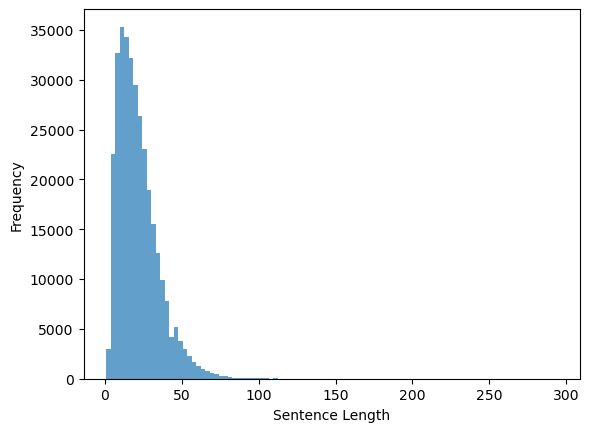

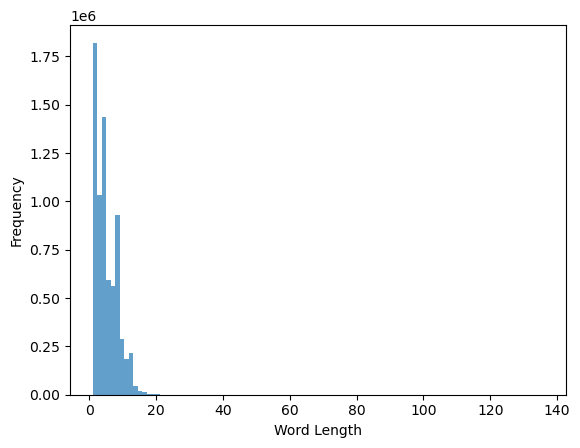

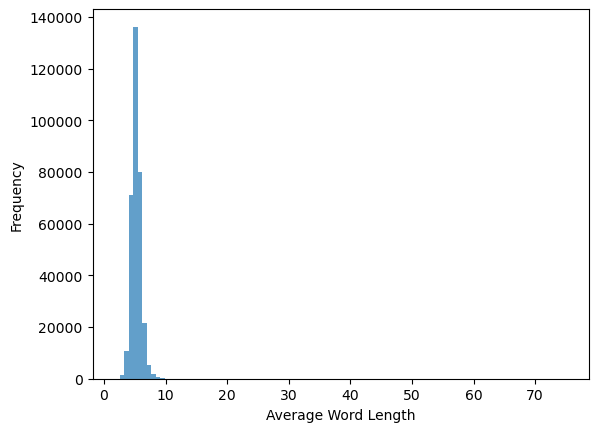

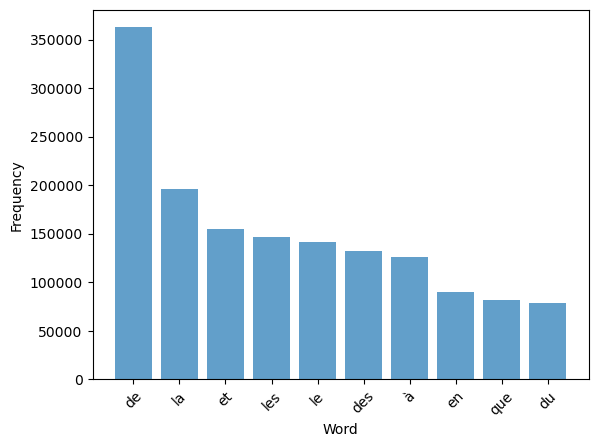

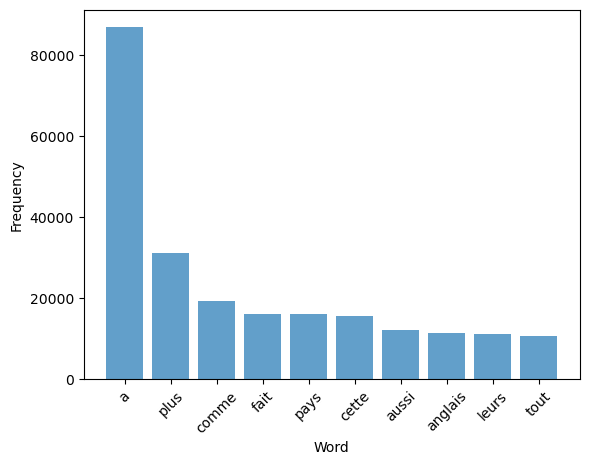

Total french word : 7158000
Average french sentence length: 21.728176205249003
Median french sentence length: 19.0
Average french word length: 5.188764459346186
Median french word length: 4.0
Longest french word : ignorez-simplement-ce-que-l'essai-dit-il-est-seulement-destiné-à-la-consommation-intérieure-et-contient-beaucoup-de-phrases-cryptées-qui (Length: 136)
Shortest french word : : (Length: 1)
Longest french sentence : Nous arrivons, quand l'été arrive Nos pas peuvent être doux, nos pas peuvent être fermes Nos voix peuvent être belles, nos voix peuvent être rauques Nos poings peuvent être levés vers le ciel, nos poings peuvent être levés contre l'injustice Nos coeurs peuvent être aussi rouges que le sang, nos cœurs peuvent être aussi verts que l'herbe Quand nous traversons le mur et occupons cette rue, cette place et cette forteresse Quand d'autres considèrent cet endroit comme un guichet automatique, un mégaphone ou une sortie de secours Nous considérons cet endroit comme un berc

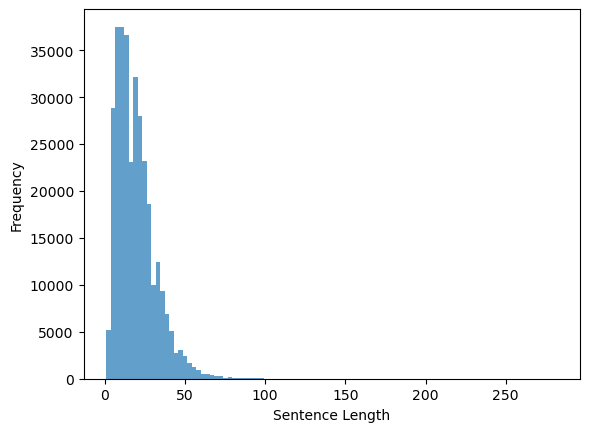

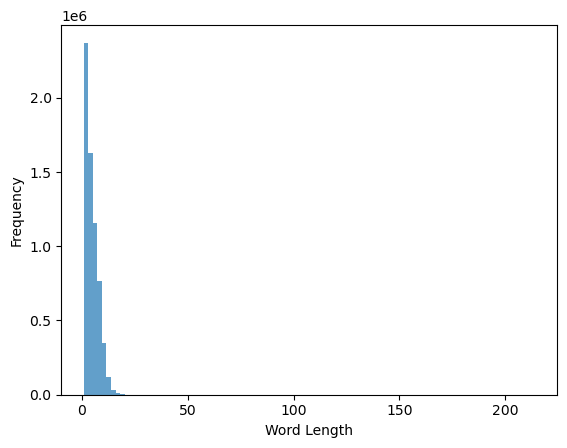

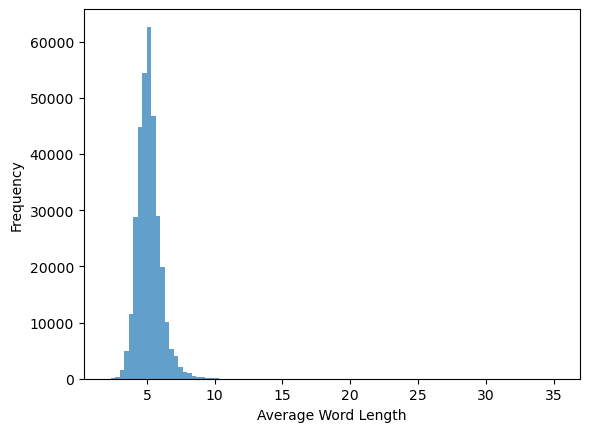

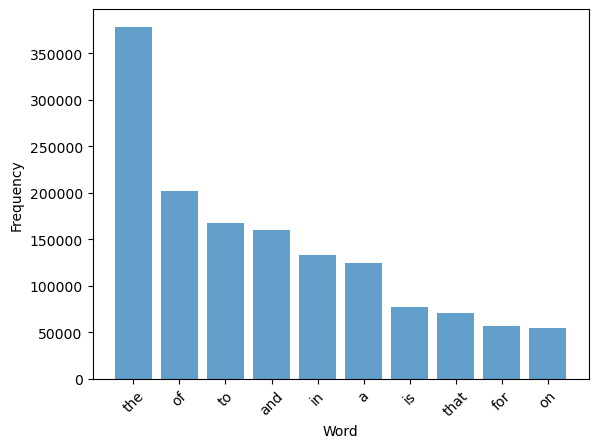

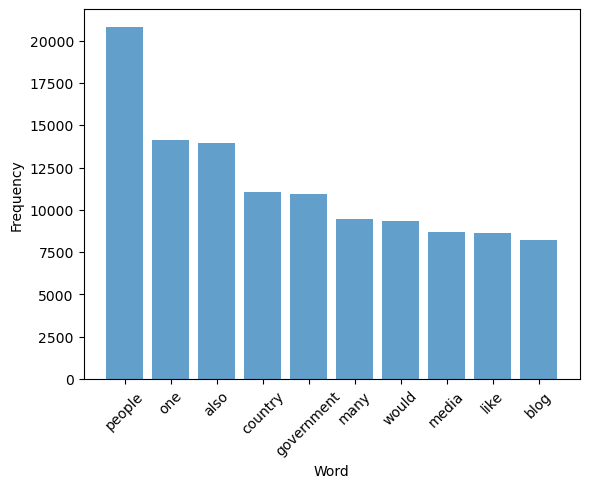

Total english word : 6429741
Average english sentence length: 19.517539173248664
Median english sentence length: 17.0
Average english word length: 5.075886882535393
Median english word length: 4.0
Longest english word : understood-in-the-context-of-Japanese-election-propaganda-and-in-Japan-nobody-believes-anything-printed-especially-when-the-author's-stringing-together-of-platitudinous-utterances-makes-him-sound-like-he-is-stoned” (Length: 214)
Shortest english word : a (Length: 1)
Longest french sentence : We are coming, when the summer is coming Our footsteps can be soft, our footsteps can be firm Our sounds can be beautiful, our sounds can be hoarse Our fists can be raised up toward the sky, our fists can be raised up against injustice Our hearts can be as red as blood, our hearts can be as green as the grass When we cross the wall and occupy this street, this square and this fortress When others consider this place an ATM, a megaphone, or a fire escape We consider this place a warm

In [24]:
french_sentences_lengths,english_sentences_lengths,french_word_lengths,english_word_lengths,french_words_count,eng_words_count,avg_french_words_lengths_by_sentence,avg_english_words_lengths_by_sentence=sentence_length(cleaned_data,"base")

## Add new sample

In [25]:
add_test=np.load(os.getcwd()+"/add_test.npy")
add_valid=np.load(os.getcwd()+"/add_valid.npy")
add_train=np.load(os.getcwd()+"/add_train.npy")

In [26]:
filtered_data_test_plus = np.array([sentence for sentence in add_test if not contains_link(sentence[0]) and not contains_link(sentence[1])])

print(len(filtered_data_test_plus))
    
filtered_data_test_plus=clean_array_of_sentences(filtered_data_test_plus)
filtered_data_test_plus = filtered_data_test_plus.astype('U1781')

def remove_backslashes(cell):
    return cell.replace("\"", "'")

# Use np.vectorize to apply the function element-wise to the array
vectorized_function = np.vectorize(remove_backslashes)
filtered_data_test_plus = vectorized_function(filtered_data_test_plus)

result=[]
for sentences in filtered_data_test_plus:
    if(len(sentences[0].split())<50) or (len(sentences[0].split())<50):
       result.append(sentences)

filtered_data_test_plus=np.array(result)

print(filtered_data_test_plus.shape)

4993
(4604, 2)


In [27]:
filtered_data_valid_plus = np.array([sentence for sentence in add_valid if not contains_link(sentence[0]) and not contains_link(sentence[1])])

print(len(filtered_data_valid_plus))
    
filtered_data_valid_plus=clean_array_of_sentences(filtered_data_valid_plus)
filtered_data_valid_plus = filtered_data_valid_plus.astype('U1781')

vectorized_function = np.vectorize(remove_backslashes)
filtered_data_valid_plus = vectorized_function(filtered_data_valid_plus)

result=[]
for sentences in filtered_data_valid_plus:
    if(len(sentences[0].split())<50) or (len(sentences[0].split())<50):
       result.append(sentences)

filtered_data_valid_plus=np.array(result)

print(filtered_data_valid_plus.shape)

4996
(4574, 2)


In [28]:
filtered_data_train_plus = np.array([sentence for sentence in add_train if not contains_link(sentence[0]) and not contains_link(sentence[1])])

print(len(filtered_data_train_plus))
    
filtered_data_train_plus=clean_array_of_sentences(filtered_data_train_plus)
filtered_data_train_plus = filtered_data_train_plus.astype('U1781')

vectorized_function = np.vectorize(remove_backslashes)
filtered_data_train_plus = vectorized_function(filtered_data_train_plus)

result=[]
for sentences in filtered_data_train_plus:
    if(len(sentences[0].split())<50) or (len(sentences[0].split())<50):
       result.append(sentences)

filtered_data_train_plus=np.array(result)

print(filtered_data_train_plus.shape)

39942
(36195, 2)


In [29]:
filtered_data_plus=np.concatenate((filtered_data_train_plus,filtered_data_test_plus))
filtered_data_plus=np.concatenate((filtered_data_plus,filtered_data_valid_plus))

## Function

In [3]:
def is_good_language(text):
    threshold=0.7
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    lang_en, confidence_en = identifier.classify(text["en"])
    lang_fr, confidence_fr = identifier.classify(text["fr"])
    return (lang_en == "en" and confidence_en > threshold) and (lang_fr == "fr" and confidence_fr > threshold)

def identify_language(text):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    lang_en, confidence_en = identifier.classify(text["en"])
    lang_fr, confidence_fr = identifier.classify(text["fr"])
    return [[lang_en,round(confidence_en,2)],[lang_fr,round(confidence_fr,2)]]

def identify_dataframe(translation_dataframe):
    return translation_dataframe.apply(lambda x: identify_language(x), axis=1)

def delete_error_fr_eng(translation_dataframe):
    condition = translation_dataframe.apply(lambda x: is_good_language(x), axis=1)
    filtered_df = translation_dataframe[condition]

    return filtered_df

def calculate_vocabulary_sizes(training_data):
    french_vocab = set()
    english_vocab = set()


    for french_sentence, english_sentence in training_data:
        french_tokens = french_sentence.split()
        french_vocab.update(french_tokens)

        english_tokens = english_sentence.split()
        english_vocab.update(english_tokens)

    return len(french_vocab), len(english_vocab)

In [9]:
cleaned_data_pd=pd.DataFrame(cleaned_data,columns=["en","fr"])

In [12]:
identify_dataframe(cleaned_data_pd.head(10))

0    [[de, 0.7], [fr, 0.97]]
1     [[en, 1.0], [fr, 1.0]]
2     [[en, 1.0], [fr, 1.0]]
3     [[en, 1.0], [fr, 1.0]]
4     [[en, 1.0], [fr, 1.0]]
5    [[en, 0.97], [hu, 0.5]]
6     [[en, 1.0], [fr, 1.0]]
7     [[en, 1.0], [fr, 1.0]]
8     [[en, 1.0], [fr, 1.0]]
9     [[en, 1.0], [fr, 1.0]]
dtype: object

In [10]:
french_vocab_size, english_vocab_size=calculate_vocabulary_sizes(cleaned_data)
print("French Vocabulary Size:", french_vocab_size)
print("English Vocabulary Size:", english_vocab_size)

French Vocabulary Size: 334620
English Vocabulary Size: 357520


In [9]:
# Split data into training and validation sets
train_data, test_data = train_test_split(cleaned_data, test_size=0.2, random_state=state,shuffle=True)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=state,shuffle=True)

In [4]:
train_data=np.load(os.getcwd()+"/Train_dataset.npy",allow_pickle=True)
val_data=np.load(os.getcwd()+"/Val_dataset.npy",allow_pickle=True)
test_data=np.load(os.getcwd()+"/Test_dataset.npy",allow_pickle=True)

In [5]:
length=50
result=np.zeros((length,length))
for i in range(len(cleaned_data)):
    eng=len(cleaned_data[i][0].split())
    fr=len(cleaned_data[i][1].split())
    if(eng <length and fr<length):
        result[eng,fr]=result[eng,fr]+1

result=result/np.max(result)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


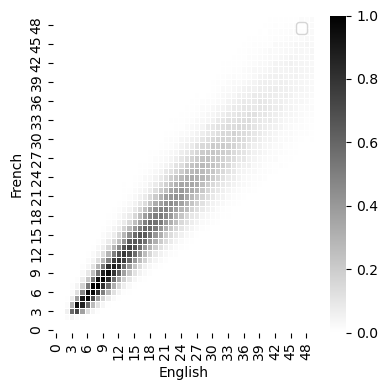

In [6]:
import seaborn as sns

plt.figure(figsize=(4, 4))

sns.heatmap(result, cmap="gray_r", fmt=".2f", linewidths=.5)
plt.xlabel("English")
plt.ylabel("French")
# Display the heatmap
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
length=50
result=np.zeros((length,length))
for i in range(len(filtered_data_plus)):
    eng=len(filtered_data_plus[i][0].split())
    fr=len(filtered_data_plus[i][1].split())
    if(eng <length and fr<length):
        result[eng,fr]=result[eng,fr]+1

result=result/np.max(result)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


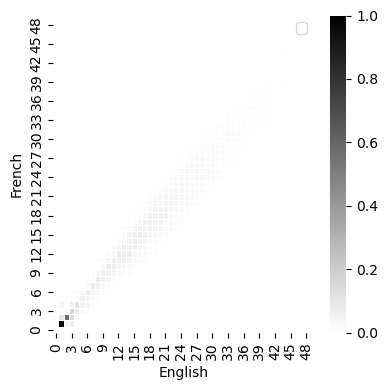

In [31]:
import seaborn as sns

plt.figure(figsize=(4, 4))

sns.heatmap(result, cmap="gray_r", fmt=".2f", linewidths=.5)
plt.xlabel("English")
plt.ylabel("French")
# Display the heatmap
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

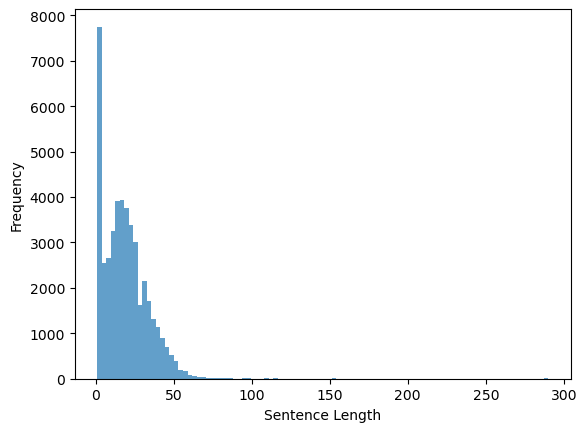

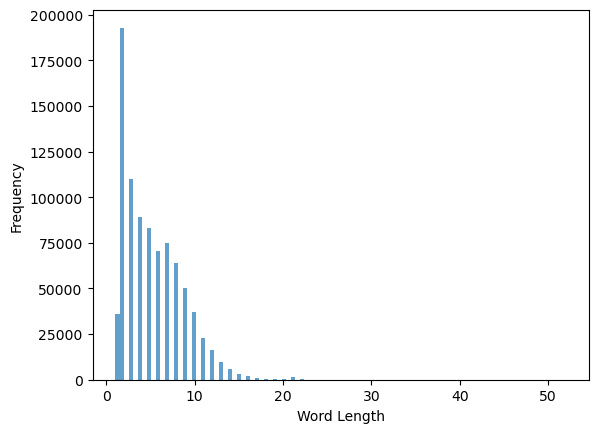

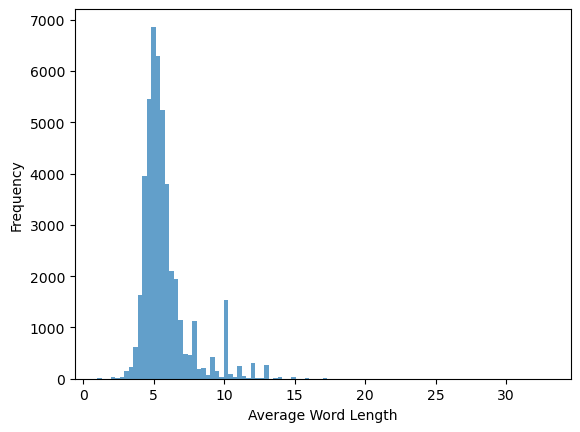

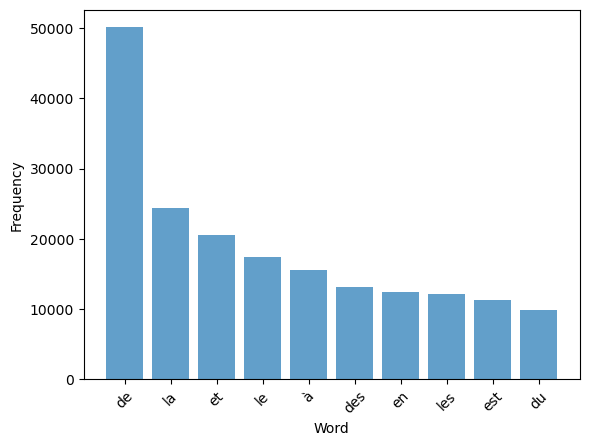

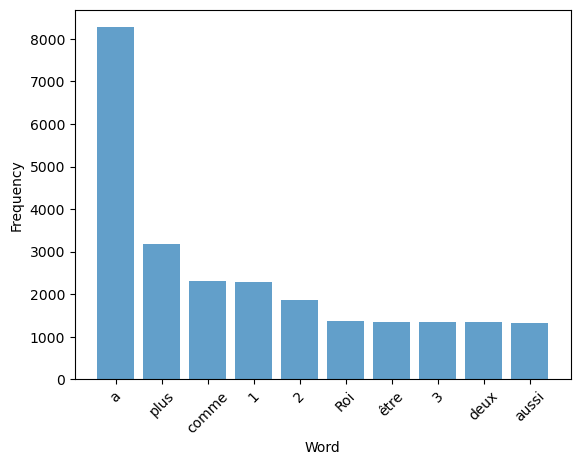

Total french word : 871151
Average french sentence length: 19.19976638088731
Median french sentence length: 17.0
Average french word length: 5.298151525969665
Median french word length: 5.0
Longest french word : fumée.'【グループ名は、煙のようにさまざまな形に姿を変える日本の妖怪「煙々羅」にちなんだ。】[5] (Length: 52)
Shortest french word : a (Length: 1)
Longest french sentence : Si le premier auteur est aussi directeur de publication (si c'est le cas, indiquer oui) Auteur 4 Nom complet d'un auteur prénom4 nom4 Postnom auteur 4 Postnom d'un auteur Lien auteur 4 Nom de l’article Wikipédia sur le premier auteur Responsabilité auteur Responsabilité assumée par le premier auteur Directeur? Si le premier auteur est aussi directeur de publication (si c'est le cas, indiquer oui) Auteur 5 Nom complet d'un auteur Auteur 6 Nom complet d'un auteur Auteur 7 Nom complet d'un auteur Auteur 8 Nom complet d'un auteur Auteur 9 Nom complet d'un auteur Auteur 10 Nom complet d'un auteur et al. ? Si ce paramètre vaut oui, « et al. » sera inséré à 

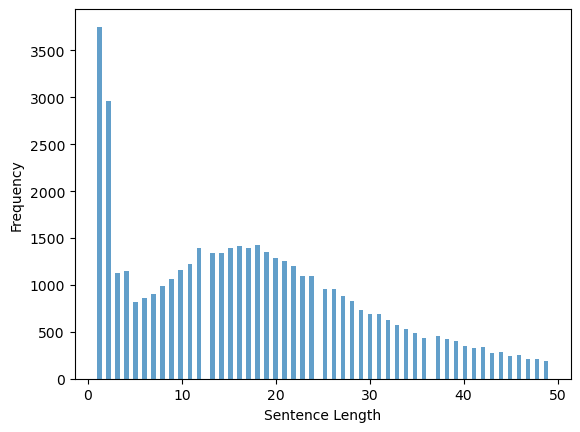

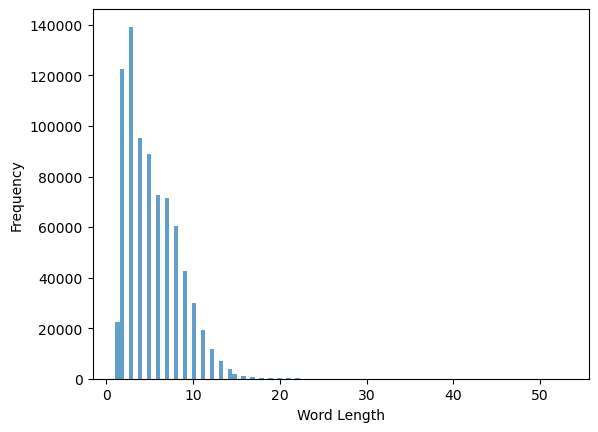

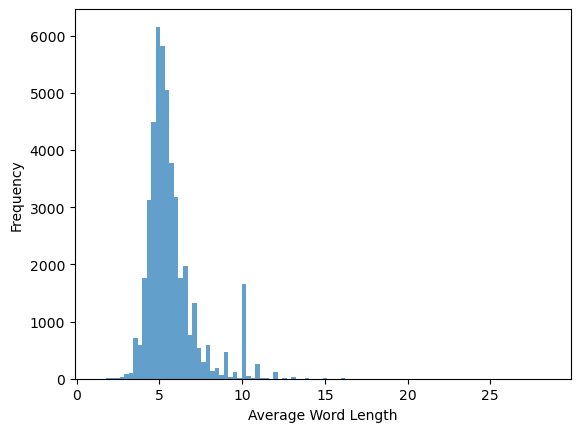

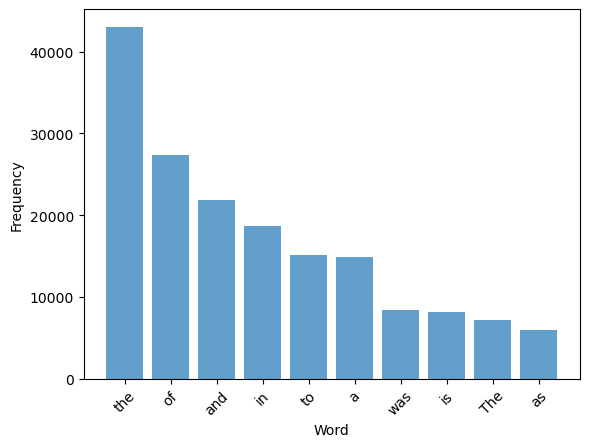

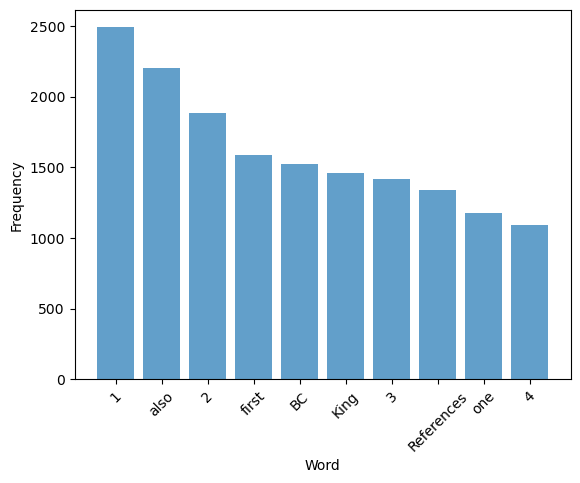

Total english word : 793100
Average english sentence length: 17.479558327639786
Median english sentence length: 16.0
Average english word length: 5.296299331736225
Median english word length: 5.0
Longest english word : enenra.'【グループ名は、煙のようにさまざまな形に姿を変える日本の妖怪「煙々羅」にちなんだ。】[5] (Length: 53)
Shortest english word : a (Length: 1)
Longest french sentence : Many Reform Jews were guided by values reflected in the Reform branch's Pittsburgh Platform, which urged Jews to 'participate in the great task of modern times, to solve, on the basis of justice and righteousness, the problems presented by the contrasts and evils of the present organization of society.'[36] (Length: 49)
Shortest french sentence : Beginnings (Length: 1)
Vocabulary size english : 110971


In [30]:
french_sentences_lengths,english_sentences_lengths,french_word_lengths,english_word_lengths,french_words_count,eng_words_count,avg_french_words_lengths_by_sentence,avg_english_words_lengths_by_sentence=sentence_length(filtered_data_plus,"plus")

In [2]:
df_V1 = pd.read_csv('test_lstm_25_base.csv').iloc[:3000]
df_V2 = pd.read_csv('test_lstm_25_base.csv').iloc[:3000]
df_V3 = pd.read_csv('test_lstm_25_base.csv').iloc[:3000]
df_V4 = pd.read_csv('test_lstm_25_base.csv').iloc[:3000]
df_V5 = pd.read_csv('test_lstm_25_base.csv').iloc[:3000]
df_V6 = pd.read_csv('test_lstm_25_base.csv').iloc[:3000]

In [80]:
from nltk.tokenize import word_tokenize
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

def bleu_meteor(df) :
    pattern = r'<eos>$'
    chencherry = nltk.translate.bleu_score.SmoothingFunction()

    df['English'] = df['English'].str.replace(pattern, '', regex=True)

    def count_words(text):
        words = text.split()
        return len(words)

    df['num_word'] = df['French'].apply(lambda x: count_words(x))

    def calculate_meteor(reference, translation):
        translation_tokens = word_tokenize(translation)
        reference_tokens = word_tokenize(reference)
        meteor_s = meteor_score([reference_tokens], translation_tokens)
        return meteor_s

    df['meteor_score'] = df.apply(lambda row: calculate_meteor(row['English'], row['Predicted English']), axis=1)
    
    def calculate_bleu(reference, translation):

        translation_tokens = word_tokenize(translation)
        reference_tokens = word_tokenize(reference)
        bleu_score = sentence_bleu([reference_tokens], translation_tokens,smoothing_function=chencherry.method4)

        return bleu_score

    df['bleu_score'] = df.apply(lambda row: calculate_bleu(row['English'], row['Predicted English']), axis=1)

    return df

In [90]:
def create_boxplots(dataframes, score_column, df_names):
    bins = [-1, 10, 20, 30, 40, float('inf')]
    labels = ['0-10', '11-20', '21-30', '31-40', '41+', 'all']
    num_dfs = len(dataframes)
    colors = ['#3DA4D5','#77AA77', '#A0D8DE',  '#00ced1', '#88CC88','#94B9C2','#008080']
    colors_contours = ['#000000','#000000', '#000000', '#000000', '#000000','#000000','#000000']

    all_data = pd.DataFrame()

    # Concatenate the dataframes with an identifying column
    for i, df in enumerate(dataframes):
        df['DataFrame'] = f'Model {i+1}'
        df['word_range'] = pd.cut(df['num_word'], bins=bins, labels=labels[:-1])  # Excludes 'all' label
        all_data = pd.concat([all_data, df], ignore_index=True)

    # Define the figure size
    plt.figure(figsize=(12, 6))

    flierprops = dict(marker='o', markerfacecolor='none', markersize=0, linestyle='none')
    # Create grouped boxplots
    for i, label in enumerate(labels):
        for j in range(num_dfs):
            # Select data for plotting
            if label == 'all':
                data_to_plot = all_data[all_data['DataFrame'] == f'Model {j+1}'][score_column].dropna()
            else:
                data_to_plot = all_data[(all_data['DataFrame'] == f'Model {j+1}') & 
                                        (all_data['word_range'] == label)][score_column].dropna()

            # Position for the boxplot
            position = (i * num_dfs * 1.5) + 1 + j
          
            # Create a boxplot for the DataFrame
            plt.boxplot(data_to_plot, positions=[position], widths=0.3, patch_artist=True, 
                        boxprops=dict(facecolor=colors[j], color=colors_contours[j]),
                        medianprops=dict(color=colors_contours[j]),
                        whiskerprops=dict(color='black'),
                        capprops=dict(color='black'),
                        flierprops=flierprops)

    # Add titles and labels
    plt.xlabel('Word Count Category')
    plt.ylabel(score_column)

    # Set the x-tick labels
    tick_positions = [num_dfs * 0.75 + i * num_dfs * 1.5 for i in range(len(labels))]
    plt.xticks(tick_positions, labels)

    # Add a legend
    legend_handles = [plt.Line2D([0], [0], color=colors[i], lw=4) for i in range(num_dfs)]
    plt.legend(legend_handles, df_names,loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3,  frameon=False)

    plt.tight_layout()
    plt.show()

In [97]:
def create_bleu_score_barplot(dataframes, actual_col, pred_col, df_names):
    bins = [-1, 10, 20, 30, 40, float('inf')]
    labels = ['0-10', '11-20', '21-30', '31-40', '41+', 'all']
    num_dfs = len(dataframes)
    bar_width = 0.10
    colors = ['#3DA4D5','#77AA77', '#A0D8DE',  '#00ced1', '#88CC88','#94B9C2','#008080']
    plt.figure(figsize=(12, 4))
    positions = np.arange(len(labels))
    chencherry = nltk.translate.bleu_score.SmoothingFunction()

    for j, df in enumerate(dataframes):
        if 'all' in labels:
            df['word_range'] = pd.cut(df['num_word'], bins=bins, labels=labels[:-1])  # Exclude 'all' for binning
        else:
            df['word_range'] = pd.cut(df['num_word'], bins=bins, labels=labels)

        for i, label in enumerate(labels):
            if label == 'all':
                subset = df  # Use the entire DataFrame for 'all'
            else:
                subset = df[df['word_range'] == label]

            actual = subset[actual_col].tolist()
            pred = subset[pred_col].tolist()

            if len(actual) > 0:
                score = nltk.translate.bleu_score.corpus_bleu([[ref] for ref in actual], pred, smoothing_function=chencherry.method4)
                position = positions[i] + j * bar_width
                color = colors[j % len(colors)]
                plt.bar(position, score, width=bar_width, color=color, edgecolor='black')
                plt.text(position, score, f'{score:.2f}', ha='center', va='bottom', fontsize=7)

    # Add titles and labels
    plt.xlabel('Word Count Range')
    plt.ylabel('BLEU Score')
    plt.xticks(positions + (bar_width * (num_dfs - 1) / 2), labels)
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], edgecolor='black', lw=2) for i in range(num_dfs)]
    plt.legend(legend_handles, df_names,loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3,  frameon=False)
    plt.tight_layout()
    plt.show()

In [10]:
print(cleaned_data.shape)
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(329434, 2)
(263547, 2)
(32943, 2)
(32944, 2)


In [49]:
np.save(os.getcwd()+"/Train_dataset.npy",pd.DataFrame(train_data,columns=["en","fr"]))
np.save(os.getcwd()+"/Val_dataset.npy",pd.DataFrame(val_data,columns=["en","fr"]))
np.save(os.getcwd()+"/Test_dataset.npy",pd.DataFrame(test_data,columns=["en","fr"]))

In [11]:
train_data_plus=np.concatenate((train_data,filtered_data_train_plus),axis=0)
val_data_plus=np.concatenate((val_data,filtered_data_valid_plus),axis=0)
test_data_plus=np.concatenate((test_data,filtered_data_test_plus),axis=0)

In [12]:
print(train_data_plus.shape)
print(val_data_plus.shape)
print(test_data_plus.shape)

(299742, 2)
(37517, 2)
(37548, 2)


In [13]:
np.save(os.getcwd()+"/Train_dataset_plus.npy",pd.DataFrame(train_data_plus,columns=["en","fr"]))
np.save(os.getcwd()+"/Val_dataset_plus.npy",pd.DataFrame(val_data_plus,columns=["en","fr"]))
np.save(os.getcwd()+"/Test_dataset_plus.npy",pd.DataFrame(test_data_plus,columns=["en","fr"]))

In [56]:
train_data_plus.shape

(303489, 2)

# Custom Dataset

In [8]:
class Custom_Dataset_Marian(Dataset):
    def __init__(self, data, model,token):
        self.data = data
        self.model = model
        self.tokenizer = token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        source_text, target_text = item[1], item[0]

        source = self.tokenizer(source_text, return_tensors="pt", padding="max_length", truncation=True, max_length=self.model.config.max_length)
        target = self.tokenizer(target_text, return_tensors="pt", padding="max_length", truncation=True, max_length=self.model.config.max_length)

        with torch.no_grad():
            outputs = self.model.generate(input_ids=source.input_ids.to(self.model.device),
                                          attention_mask=source.attention_mask.to(self.model.device),
                                          max_length=100,
                                          num_return_sequences=1,
                                          num_beams=4,
                                          early_stopping=True)
        decoded_output = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        return {
            "input_ids": source["input_ids"].flatten(),
            "attention_mask": source["attention_mask"].flatten(),
            "labels": target["input_ids"].flatten(),
            "decoder_attention_mask": target["attention_mask"].flatten(),
            "decoded_target": target_text,
            "decoded_output": decoded_output
        }

In [6]:
def freeze_layers(model, num_layers_to_keep_trainable):
    if num_layers_to_keep_trainable == 'Encoder':
        # Freeze decoder
        for name, param in model.named_parameters():
            if "encoder" in name:
                param.requires_grad=False
                print(f"Parameter: {name}, Requires Grad: {param.requires_grad}")
    else:
        total_layers = len(list(model.named_parameters()))

        for idx, (name, param) in enumerate(model.named_parameters()):
            if idx < total_layers - num_layers_to_keep_trainable:
                param.requires_grad = False
            else:
                param.requires_grad = True

def bleu_score(True_label,pred_label,n_gram):
    smooth = nltk.translate.bleu_score.SmoothingFunction().method1
    weights=[]
    for v in range(1,n_gram+1):
        weights.append(tuple(1 / v for _ in range(1, v + 1)))
        
    return nltk.translate.bleu_score.sentence_bleu([True_label.split()],pred_label.split(),weights=weights, smoothing_function=smooth)

def meteor_score(True_label,pred_label):
    return nltk.translate.meteor_score.meteor_score([nltk.tokenize.word_tokenize(True_label.lower())], nltk.tokenize.word_tokenize(pred_label.lower()))

def rouge_score(True_label,pred_label):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    return scorer.score(True_label, pred_label)

def calculate_accuracy(True_labels,pred_labels,n_gram):
    sum_bleu=[0]*n_gram
    sum_meteor=0
    avg_rouge = {metric: {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0} for metric in ['rouge1', 'rouge2', 'rougeL']}

    bleu_list=[]
    meteor_list=[]
    rouge_list=[]
    for i in range(len(True_labels)):
        res_bleu=bleu_score(True_labels[i],pred_labels[i],n_gram)
        bleu_list.append(res_bleu)
        sum_bleu=[x + y for x, y in zip(sum_bleu,res_bleu)]

        res_meteor=meteor_score(True_labels[i],pred_labels[i])
        meteor_list.append(res_meteor)
        sum_meteor+=res_meteor

        scores = rouge_score(True_labels[i],pred_labels[i])
        rouge_list.append(scores)
        for metric, value in scores.items():
            avg_rouge[metric]["precision"] += value.precision
            avg_rouge[metric]["recall"] += value.recall
            avg_rouge[metric]["fmeasure"] += value.fmeasure
    
    for inner_dict in avg_rouge.values():
        for key, value in inner_dict.items():
            inner_dict[key] = value / len(True_labels)

    return np.array(sum_bleu)/len(True_labels),np.array(bleu_list),sum_meteor/len(True_labels),np.array(meteor_list),avg_rouge,np.array(rouge_list)

def training(num_epochs,model,nb_layer,train_loader,optimizer,n_gram,model_name):
    freeze_layers(model,nb_layer)
    train_loss=[]
    meteor_sc=[]
    bleu_sc=[]
    rouge_sc=[]

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_bleu = [0]*n_gram
        total_meteor = 0
        avg_rouge = {metric: {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0} for metric in ['rouge1', 'rouge2', 'rougeL']}
        
        for batch in tqdm(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            decoder_attention_mask = batch['decoder_attention_mask'].to(device)
            decoded_targets = batch['decoded_target']
            decoded_outputs = batch['decoded_output']

            #print("Decoded Targets:", decoded_targets)
            #print("Decoded Outputs:", decoded_outputs)

            acc_bleu,bleu_list,acc_meteor,meteor_list,acc_rouge,rouge_list=calculate_accuracy(decoded_targets,decoded_outputs,n_gram)
            optimizer.zero_grad()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                decoder_attention_mask=decoder_attention_mask,
            )

            for metric, value in acc_rouge.items():
                avg_rouge[metric]["precision"] += value["precision"]
                avg_rouge[metric]["recall"] += value["recall"]
                avg_rouge[metric]["fmeasure"] += value["fmeasure"]
            
            
            
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_bleu =[x + y for x, y in zip(total_bleu, acc_bleu)]
            total_meteor +=acc_meteor

        avg_train_loss = total_loss / len(train_loader)
        avg_bleu=np.array(total_bleu)/len(train_loader)
        avg_meteor=total_meteor/len(train_loader)

        for inner_dict in avg_rouge.values():
            for key, value in inner_dict.items():
                inner_dict[key] = value / len(train_loader)

        train_loss.append(avg_train_loss)
        meteor_sc.append(avg_meteor)
        bleu_sc.append(avg_bleu)
        rouge_sc.append(avg_rouge)

        formatted_scores = ', '.join(f"Avg. Bleu Score {index + 1}-gram : {score:.2f}" for index, score in enumerate(avg_bleu))

        formatted_rouge = ', '.join([f"Avg. Rouge {key} Recall : {avg_rouge[key]['recall']:.2f}" for key in avg_rouge.keys()])

        print(f"Epoch {epoch+1} Avg. Val Loss: {avg_train_loss} - Avg. Meteor Score {avg_meteor} - {formatted_scores} - {formatted_rouge}")
        save_model(model,os.getcwd()+"/"+model_name+"_"+str(epoch+1))
    np.save(os.getcwd()+"/"+model_name+"_train_loss.npy",train_loss)
    np.save(os.getcwd()+"/"+model_name+"_meteor_sc.npy",meteor_sc)
    np.save(os.getcwd()+"/"+model_name+"_bleu_sc.npy",bleu_sc)
    np.save(os.getcwd()+"/"+model_name+"_rouge_sc.npy",rouge_sc)
    return train_loss,meteor_sc,bleu_sc

def testing(model,val_data,n_gram):
    with torch.no_grad():  # Ensure no gradient calculation during evaluation
        model.eval()
        total_loss = 0
        total_bleu = [0]*n_gram
        total_meteor = 0
        trad={}
        trad["decoded_targets"]=[]
        trad["decoded_outputs"]=[]
        avg_rouge = {metric: {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0} for metric in ['rouge1', 'rouge2', 'rougeL']}

        for batch in tqdm(val_data):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            decoder_attention_mask = batch['decoder_attention_mask'].to(device)
            decoded_targets = batch['decoded_target']  # Decoded target labels
            decoded_outputs = batch['decoded_output']

            #print(decoded_targets)
            #print(decoded_outputs)
            
            acc_bleu,bleu_list,acc_meteor,meteor_list,acc_rouge,rouge_list=calculate_accuracy(decoded_targets,decoded_outputs,n_gram)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                decoder_attention_mask=decoder_attention_mask,
            )
            for i in range(len(decoded_targets)):
                trad["decoded_targets"].append([decoded_targets[i].split(),bleu_list[i],meteor_list[i],rouge_list[i]])
                trad["decoded_outputs"].append([decoded_outputs[i].split(),bleu_list[i],meteor_list[i],rouge_list[i]])

            for metric, value in acc_rouge.items():
                avg_rouge[metric]["precision"] += value["precision"]
                avg_rouge[metric]["recall"] += value["recall"]
                avg_rouge[metric]["fmeasure"] += value["fmeasure"]

            loss = outputs.loss
            total_loss += loss.item()
            total_bleu = [x + y for x, y in zip(total_bleu, acc_bleu)]
            total_meteor +=acc_meteor

    avg_train_loss = total_loss / len(val_data)
    avg_bleu=np.array(total_bleu)/len(val_data)
    avg_meteor=total_meteor/len(val_data)

    for inner_dict in avg_rouge.values():
            for key, value in inner_dict.items():
                inner_dict[key] = value / len(val_data)

    formatted_bleu = ', '.join(f"Avg. Bleu Score {index + 1}Gram Overlaps: {score:.2f}" for index, score in enumerate(avg_bleu))

    formatted_rouge = ', '.join([f"Avg. Rouge {key} Recall : {avg_rouge[key]['recall']:.2f}" for key in avg_rouge.keys()])

    print(f"Avg. Val Loss: {avg_train_loss} - Avg. Meteor Score {avg_meteor} - {formatted_bleu} - {formatted_rouge}")

    return avg_train_loss,avg_meteor,avg_rouge,avg_bleu,trad

def example(data_loader,idx):
    for i, batch in enumerate(data_loader):
        if i == idx:
            decoded_targets = batch['decoded_target']
            decoded_outputs = batch['decoded_output']
            for j in range(len(decoded_targets)):
                print("Sentence "+str(j+1)+" Real ouputs :"+decoded_targets[j])
                print("Sentence "+str(j+1)+" Predicted ouputs :"+decoded_outputs[j])
                bleu_sc=bleu_score(decoded_targets[j],decoded_outputs[j])
                for v in range(len(bleu_sc)):
                    print("Sentence "+str(j+1)+" Bleu score "+str(v+2)+"-Grams overlap :"+str(bleu_sc[v]))
                print("Sentence "+str(j+1)+" Meteor score :"+str(meteor_score(decoded_targets[j],decoded_outputs[j])))
            break 

def save_model(model,name_file):
    torch.save(model, name_file+'.pth')


## Pre-trained : Helsinki-NLP

### Model 1

In [13]:
model_name="Helsinki-NLP/opus-mt-fr-en"

token = MarianTokenizer.from_pretrained(model_name)

modelV1 = MarianMTModel.from_pretrained(model_name)
modelV1=torch.load(os.getcwd()+'/MARIANMT_1/MARIANMT_1_3.pth')


train_dataset=Custom_Dataset_Marian(train_data,modelV1,token)
val_dataset=Custom_Dataset_Marian(val_data,modelV1,token)
test_dataset=Custom_Dataset_Marian(test_data,modelV1,token)

train_loader = DataLoader(train_dataset, batch_size=8)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

optimizer = torch.optim.Adam(modelV1.parameters(), lr=3e-5)

modelV1.to(device)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

#### Example

In [55]:
french_text = "Bonjour, comment ça va?"

inputs = token(french_text, truncation=True, return_tensors="pt")

outputs = modelV1.generate(**inputs.to(device))
translated_text = token.decode(outputs[0], skip_special_tokens=True)

print("French Text: ", french_text)
print("English Translation: ", translated_text)

French Text:  Bonjour, comment ça va?
English Translation:  Hi, how are you doing?


In [ ]:
train_loss,meteor_sc,bleu_sc=training(3,model,2,train_loader,optimizer,4)

In [17]:
avg_train_loss,avg_meteor,avg_rouge,avg_bleu,trad_model1=testing(modelV1,test_loader,4)

100%|██████████| 375/375 [14:00<00:00,  2.24s/it]

Avg. Val Loss: 0.1282841513554255 - Avg. Meteor Score 0.5741315048227902 - Avg. Bleu Score 1Gram Overlaps: 0.49, Avg. Bleu Score 2Gram Overlaps: 0.36, Avg. Bleu Score 3Gram Overlaps: 0.27, Avg. Bleu Score 4Gram Overlaps: 0.20 - Avg. Rouge rouge1 Recall : 0.64, Avg. Rouge rouge2 Recall : 0.39, Avg. Rouge rougeL Recall : 0.61


In [25]:
for i in tqdm(range(df_V1["French"].shape[0])):
    french_text=df_V1["French"].iloc[i]
    inputs = token(french_text, truncation=True, return_tensors="pt")
    outputs = modelV1.generate(**inputs.to(device))
    translated_text = token.decode(outputs[0], skip_special_tokens=True)
    df_V1["Predicted English"].iloc[i]=translated_text

100%|██████████| 3000/3000 [14:38<00:00,  3.42it/s]


In [35]:
df_V1 =  bleu_meteor(df_V1).copy()

In [36]:
df_V1.to_csv(os.getcwd()+'/MARIANMT_1/df_V1.csv', index=False)

### Model 2

In [31]:
model_name="Helsinki-NLP/opus-mt-fr-en"

token = MarianTokenizer.from_pretrained(model_name)

modelV2=torch.load(os.getcwd()+'/MARIANMT_2/MARIANMT_2_3.pth')


train_dataset=Custom_Dataset_Marian(train_data,modelV2,token)
val_dataset=Custom_Dataset_Marian(val_data,modelV2,token)
test_dataset=Custom_Dataset_Marian(test_data[:3000],modelV2,token)

train_loader = DataLoader(train_dataset, batch_size=8)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

optimizer = torch.optim.Adam(modelV2.parameters(), lr=3e-5)

modelV2.to(device)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [ ]:
avg_train_loss,avg_meteor,avg_rouge,avg_bleu,trad_model2=testing(modelV2,test_loader,4)

In [32]:
for i in tqdm(range(df_V2["French"].shape[0])):
    french_text=df_V2["French"].iloc[i]
    inputs = token(french_text, truncation=True, return_tensors="pt")
    outputs = modelV2.generate(**inputs.to(device))
    translated_text = token.decode(outputs[0], skip_special_tokens=True)
    df_V2["Predicted English"].iloc[i]=translated_text

100%|██████████| 3000/3000 [13:52<00:00,  3.60it/s]


In [41]:
df_V2 =  bleu_meteor(df_V2).copy()

In [42]:
df_V2.to_csv(os.getcwd()+'/MARIANMT_2/df_V2.csv', index=False)

### Model 3

In [40]:
model_name="Helsinki-NLP/opus-mt-fr-en"

token = MarianTokenizer.from_pretrained(model_name)

modelV3 = MarianMTModel.from_pretrained(model_name)
modelV3=torch.load(os.getcwd()+'/MARIANMT_schedule/MARIANMT_schedule_3.pth')


train_dataset=Custom_Dataset_Marian(train_data,modelV3,token)
val_dataset=Custom_Dataset_Marian(val_data,modelV3,token)
test_dataset=Custom_Dataset_Marian(test_data[:3000],modelV3,token)

train_loader = DataLoader(train_dataset, batch_size=8)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

optimizer = torch.optim.Adam(modelV3.parameters(), lr=3e-5)

modelV3.to(device)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [51]:
avg_train_loss,avg_meteor,avg_rouge,avg_bleu,trad_model3=testing(modelV3,test_loader,4)

100%|██████████| 375/375 [14:15<00:00,  2.28s/it]

Avg. Val Loss: 0.10183620751897494 - Avg. Meteor Score 0.593267965323222 - Avg. Bleu Score 1Gram Overlaps: 0.50, Avg. Bleu Score 2Gram Overlaps: 0.38, Avg. Bleu Score 3Gram Overlaps: 0.29, Avg. Bleu Score 4Gram Overlaps: 0.23 - Avg. Rouge rouge1 Recall : 0.67, Avg. Rouge rouge2 Recall : 0.42, Avg. Rouge rougeL Recall : 0.63


In [43]:
for i in tqdm(range(df_V3["French"].shape[0])):
    french_text=df_V3["French"].iloc[i]
    inputs = token(french_text, truncation=True, return_tensors="pt")
    outputs = modelV3.generate(**inputs.to(device))
    translated_text = token.decode(outputs[0], skip_special_tokens=True)
    df_V3["Predicted English"].iloc[i]=translated_text

100%|██████████| 3000/3000 [13:50<00:00,  3.61it/s]


In [44]:
df_V3 =  bleu_meteor(df_V3).copy()

In [45]:
df_V3.to_csv(os.getcwd()+'/MARIANMT_schedule/df_V3.csv', index=False)

### Model 4

In [46]:
model_name="Helsinki-NLP/opus-mt-fr-en"

token = MarianTokenizer.from_pretrained(model_name)

modelV4 = MarianMTModel.from_pretrained(model_name)
modelV4=torch.load(os.getcwd()+'/MARIANMT_1_PLUS/MARIANMT_1_PLUS_3.pth')


train_dataset=Custom_Dataset_Marian(train_data,modelV4,token)
val_dataset=Custom_Dataset_Marian(val_data,modelV4,token)
test_dataset=Custom_Dataset_Marian(test_data[:3000],modelV4,token)

train_loader = DataLoader(train_dataset, batch_size=8)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

optimizer = torch.optim.Adam(modelV4.parameters(), lr=3e-5)

modelV4.to(device)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [54]:
avg_train_loss,avg_meteor,avg_rouge,avg_bleu,trad_model4=testing(modelV4,test_loader,4)

100%|██████████| 375/375 [17:10<00:00,  2.75s/it]

Avg. Val Loss: 0.12728042902549108 - Avg. Meteor Score 0.5776498879997949 - Avg. Bleu Score 1Gram Overlaps: 0.49, Avg. Bleu Score 2Gram Overlaps: 0.36, Avg. Bleu Score 3Gram Overlaps: 0.27, Avg. Bleu Score 4Gram Overlaps: 0.20 - Avg. Rouge rouge1 Recall : 0.64, Avg. Rouge rouge2 Recall : 0.39, Avg. Rouge rougeL Recall : 0.61


In [47]:
for i in tqdm(range(df_V4["French"].shape[0])):
    french_text=df_V4["French"].iloc[i]
    inputs = token(french_text, truncation=True, return_tensors="pt")
    outputs = modelV4.generate(**inputs.to(device))
    translated_text = token.decode(outputs[0], skip_special_tokens=True)
    df_V4["Predicted English"].iloc[i]=translated_text

100%|██████████| 3000/3000 [13:56<00:00,  3.59it/s]


In [48]:
df_V4 =  bleu_meteor(df_V4).copy()

In [49]:
df_V4.to_csv(os.getcwd()+'/MARIANMT_1_PLUS/df_V4.csv', index=False)

### Model 5

In [51]:
model_name="Helsinki-NLP/opus-mt-fr-en"

token = MarianTokenizer.from_pretrained(model_name)

modelV5 = MarianMTModel.from_pretrained(model_name)
modelV5=torch.load(os.getcwd()+'/MARIANMT_2_PLUS/MARIANMT_2_PLUS_3.pth')


train_dataset=Custom_Dataset_Marian(train_data,modelV5,token)
val_dataset=Custom_Dataset_Marian(val_data,modelV5,token)
test_dataset=Custom_Dataset_Marian(test_data[:3000],modelV5,token)

train_loader = DataLoader(train_dataset, batch_size=8)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

optimizer = torch.optim.Adam(modelV5.parameters(), lr=3e-5)

modelV5.to(device)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [52]:
for i in tqdm(range(df_V5["French"].shape[0])):
    french_text=df_V5["French"].iloc[i]
    inputs = token(french_text, truncation=True, return_tensors="pt")
    outputs = modelV5.generate(**inputs.to(device))
    translated_text = token.decode(outputs[0], skip_special_tokens=True)
    df_V5["Predicted English"].iloc[i]=translated_text

100%|██████████| 3000/3000 [16:47<00:00,  2.98it/s]


In [53]:
df_V5 =  bleu_meteor(df_V5).copy()

In [54]:
df_V5.to_csv(os.getcwd()+'/MARIANMT_2_PLUS/df_V5.csv', index=False)

### Model 6

In [11]:
model_name="Helsinki-NLP/opus-mt-fr-en"

token = MarianTokenizer.from_pretrained(model_name)

modelV6 = MarianMTModel.from_pretrained(model_name)
modelV6=torch.load(os.getcwd()+'/MARIANMT_schedule_PLUS/MARIANMT_schedule_PLUS_3.pth')


train_dataset=Custom_Dataset_Marian(train_data,modelV6,token)
val_dataset=Custom_Dataset_Marian(val_data,modelV6,token)
test_dataset=Custom_Dataset_Marian(test_data[:3000],modelV6,token)

train_loader = DataLoader(train_dataset, batch_size=8)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

optimizer = torch.optim.Adam(modelV6.parameters(), lr=3e-5)

modelV6.to(device)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [13]:
for i in tqdm(range(df_V6["French"].shape[0])):
    french_text=df_V6["French"].iloc[i]
    inputs = token(french_text, truncation=True, return_tensors="pt")
    outputs = modelV6.generate(**inputs.to(device))
    translated_text = token.decode(outputs[0], skip_special_tokens=True)
    df_V6["Predicted English"].iloc[i]=translated_text

100%|██████████| 3000/3000 [13:23<00:00,  3.74it/s]


In [23]:
df_V6

,French,English,Predicted English,num_word
0,certains penseront que cela n était pas nécess...,some people might think this is not necessary ...,some will think that this was not necessary bu...,25
1,l aspect le plus poignant de ces manifestation...,the most heart-wrenching aspect of the protest...,The most poignant aspect of the protests came ...,52
2,des camps rudimentaires ont été ouverts dans l...,rudimentary camps have been established in d i...,rudimentary camps have been opened in the regi...,26
3,ce genre de modèle marche à court terme mais j...,this kind of model will work in the short run ...,This kind of model works in the short term but...,16
4,ayotzinapa dénoncer en ligne et après,ayotzinapa duality of internet denunciation,ayotzinapa reporting online and after,6
...,...,...,...,...
2995,l aide étrangère qui représente environ 40% de...,foreign aid which makes up about 40% of malawi...,the foreign aid that▁represents▁approximately ...,25
2996,la chine renforce la censure sur les émissions...,china strengthens censorship on foreign tv onl...,▁Chinese is▁increasing censorship of foreign T...,12
2997,mordy du projet de voyages collaboratifs atlas...,mordy at collaborative travel project atlas ob...,mordy of the collaborative trips project atlas...,12
2998,lorsque nous avons lancé matenwa c était vraim...,when the matenwa school started it was very di...,when we launched matenwa it was really difficu...,11


In [28]:
df_V6 =  bleu_meteor(df_V6).copy()

In [29]:
df_V6.to_csv(os.getcwd()+'/MARIANMT_schedule_PLUS/df_V6.csv', index=False)

In [5]:
df_V1 = pd.read_csv(os.getcwd()+'/MARIANMT_1/df_V1.csv')
df_V2 = pd.read_csv(os.getcwd()+'/MARIANMT_2/df_V2.csv')
df_V3 = pd.read_csv(os.getcwd()+'/MARIANMT_schedule/df_V3.csv')
df_V4 = pd.read_csv(os.getcwd()+'/MARIANMT_1_PLUS/df_V4.csv')
df_V5 = pd.read_csv(os.getcwd()+'/MARIANMT_2_PLUS/df_V5.csv')
df_V6 = pd.read_csv(os.getcwd()+'/MARIANMT_schedule_PLUS/df_V6.csv')

In [ ]:
create_boxplots([df_V1, df_V2,df_V3,df_V4,df_V5,df_V6], 'bleu_score', df_names=['MARIANMT Finetuning \n1 layer', 'MARIANMT Finetuning \n2 layers',
                                                                                  'MARIANMT Finetuning \nwith a Learning rate schedule',
                                                                                  'MARIANMT Finetuning \n1 layer+','MARIANMT Finetuning \n2 layers+',
                                                                                  'MARIANMT Finetuning \nwith a Learning rate schedule+'])

In [3]:
model1__val_loss=np.load(os.getcwd()+'/MARIANMT_1/MARIANMT_1_val_loss.npy',allow_pickle=True)
model1__train_loss=np.load(os.getcwd()+'/MARIANMT_1/MARIANMT_1_train_loss.npy',allow_pickle=True)

model2__val_blue=np.load(os.getcwd()+'/MARIANMT_2/MARIANMT_2_val_bleu_sc.npy',allow_pickle=True)
model2__train_blue=np.load(os.getcwd()+'/MARIANMT_2/MARIANMT_2_train_bleu_sc.npy',allow_pickle=True)

model3__val_meteor=np.load(os.getcwd()+'/MARIANMT_schedule/MARIANMT_schedule_val_meteor_sc.npy',allow_pickle=True)
model3__train_meteor=np.load(os.getcwd()+'/MARIANMT_schedule/MARIANMT_schedule_train_meteor_sc.npy',allow_pickle=True)

model4__val_rouge=np.load(os.getcwd()+'/MARIANMT_1_PLUS/MARIANMT_1_PLUS_val_rouge_sc.npy',allow_pickle=True)
model4__train_rouge=np.load(os.getcwd()+'/MARIANMT_1_PLUS/MARIANMT_1_PLUS_train_rouge_sc.npy',allow_pickle=True)

model5__val_rouge=np.load(os.getcwd()+'/MARIANMT_2_PLUS/MARIANMT_2_PLUS_val_rouge_sc.npy',allow_pickle=True)
model5__train_rouge=np.load(os.getcwd()+'/MARIANMT_2_PLUS/MARIANMT_2_PLUS_train_rouge_sc.npy',allow_pickle=True)

model6__val_rouge=np.load(os.getcwd()+'/MARIANMT_schedule_PLUS/MARIANMT_schedule_PLUS_val_rouge_sc.npy',allow_pickle=True)
model6__train_rouge=np.load(os.getcwd()+'/MARIANMT_schedule_PLUS/MARIANMT_schedule_PLUS_train_rouge_sc.npy',allow_pickle=True)

In [45]:
model_name="Helsinki-NLP/opus-mt-fr-en"
model = MarianMTModel.from_pretrained(model_name)
base_lr = 0.0003
layerwise_lr_decay = 0.5

# Group model parameters by layers (for illustration, adjust as needed)
encoder_params = []
encoder_name=[]

decoder0_params = []
decoder0_name=[]

decoder1_params = []
decoder1_name=[]

decoder2_params = []
decoder2_name=[]

decoder3_params = []
decoder3_name=[]

decoder4_params = []
decoder4_name=[]

decoder5_params = []
decoder5_name=[]
for name, param in model.named_parameters():
    if 'encoder' in name:
        encoder_name.append(name)
        encoder_params.append(param)
    elif 'decoder' in name:
            if '0' in name:
                decoder0_params.append(param)
                decoder0_name.append(name)
            elif '1' in name:
                decoder1_params.append(param)
                decoder1_name.append(name)
            elif '2' in name:
                decoder2_params.append(param)
                decoder2_name.append(name)
            elif '3' in name:
                decoder3_params.append(param)
                decoder3_name.append(name)
            elif '4' in name:
                decoder4_params.append(param)
                decoder4_name.append(name)
            elif '5' in name:
                decoder5_params.append(param)
                decoder5_name.append(name)

In [33]:
optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': base_lr},
    {'params': decoder0_params, 'lr': base_lr * (layerwise_lr_decay**5)},
    {'params': decoder1_params, 'lr': base_lr * (layerwise_lr_decay**4)},
    {'params': decoder2_params, 'lr': base_lr * (layerwise_lr_decay**3)},
    {'params': decoder3_params, 'lr': base_lr * (layerwise_lr_decay**2)},
    {'params': decoder4_params, 'lr': base_lr * (layerwise_lr_decay**1)},
    {'params': decoder5_params, 'lr': base_lr},
])

In [67]:
current_lrs = [param_group['lr'] for param_group in optimizer.param_groups]

In [68]:
current_lrs.insert(0, current_lrs[0])
current_lrs.insert(0, current_lrs[0])
current_lrs.insert(0, current_lrs[0])
current_lrs.insert(0, current_lrs[0])
current_lrs.insert(0, current_lrs[0])

In [69]:
couche=["Encoder 1","Encoder 2","Encoder 3","Encoder 4","Encoder 5","Encoder 6","Decoder 1","Decoder 2","Decoder 3","Decoder 4 ","Decoder 5","Decoder 6"]

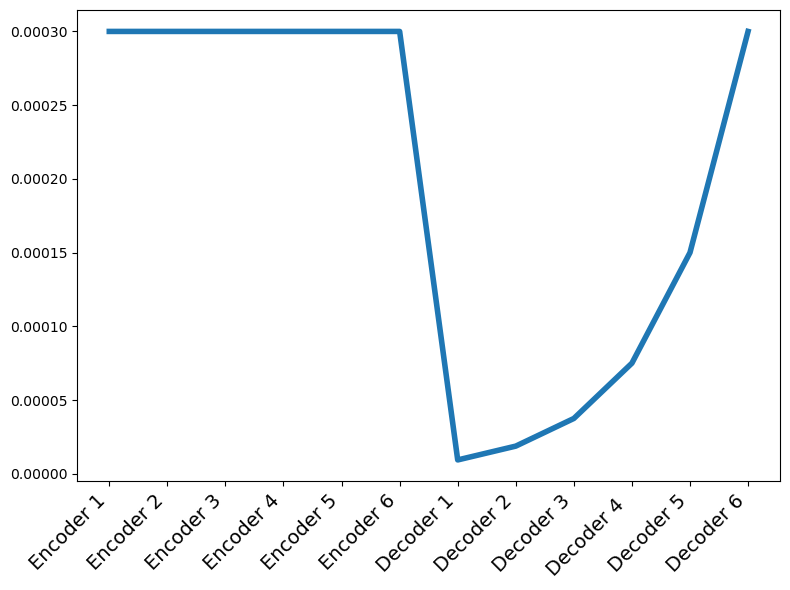

In [71]:
plt.figure(figsize=(8,6))
plt.plot(couche,current_lrs, linewidth=4)
plt.xticks(rotation=45, ha='right',fontsize=14)  # 'rotation' specifies the rotation angle, 'ha' is the horizontal alignment
plt.tight_layout()
plt.show()

### Baseline 

In [74]:
model_name="Helsinki-NLP/opus-mt-fr-en"

token = MarianTokenizer.from_pretrained(model_name)

modelV7 = MarianMTModel.from_pretrained(model_name)

modelV7.to(device)

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,),

In [75]:
df_V7 = pd.read_csv('test_lstm_25_base.csv').iloc[:3000]

In [76]:
for i in tqdm(range(df_V7["French"].shape[0])):
    french_text=df_V7["French"].iloc[i]
    inputs = token(french_text, truncation=True, return_tensors="pt")
    outputs = modelV7.generate(**inputs.to(device))
    translated_text = token.decode(outputs[0], skip_special_tokens=True)
    df_V7["Predicted English"].iloc[i]=translated_text

100%|██████████| 3000/3000 [08:26<00:00,  5.92it/s]


In [81]:
df_V7 =  bleu_meteor(df_V7).copy()

In [82]:
df_V7.to_csv(os.getcwd()+'/df_V7.csv', index=False)

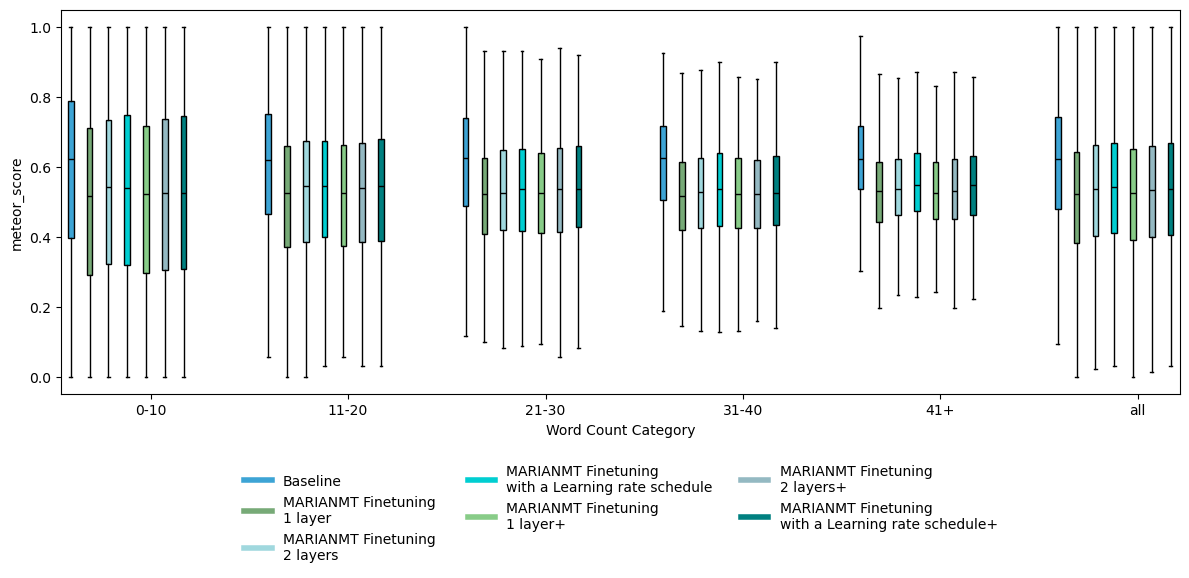

In [91]:
create_boxplots([df_V7,df_V1,df_V2,df_V3,df_V4,df_V5,df_V6], 'meteor_score', df_names=['Baseline','MARIANMT Finetuning \n1 layer', 'MARIANMT Finetuning \n2 layers',
                                                                                  'MARIANMT Finetuning \nwith a Learning rate schedule',
                                                                                  'MARIANMT Finetuning \n1 layer+','MARIANMT Finetuning \n2 layers+',
                                                                                  'MARIANMT Finetuning \nwith a Learning rate schedule+'])

C:\Users\hedir\AppData\Local\Temp\ipykernel_9360\4232111110.py:37: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], edgecolor='black', lw=2) for i in range(num_dfs)]


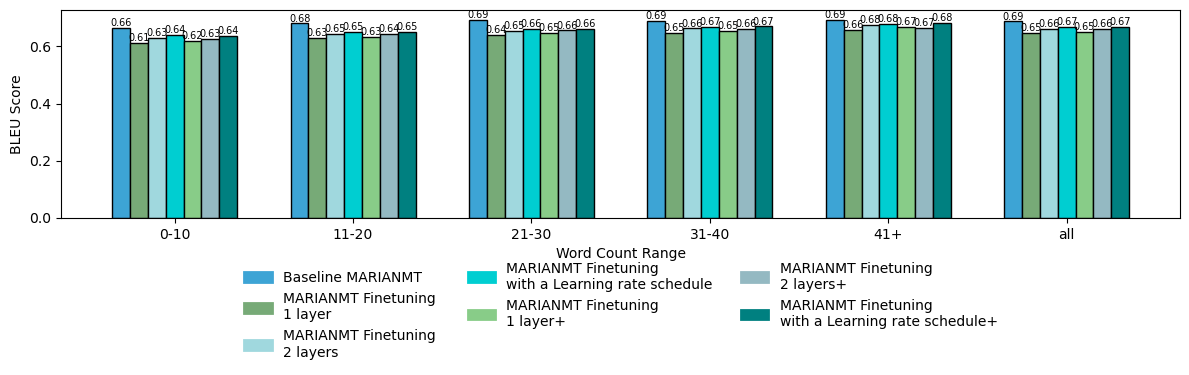

In [98]:
create_bleu_score_barplot([df_V7,df_V1, df_V2, df_V3, df_V4,df_V5,df_V6], actual_col='English', pred_col='Predicted English', 
                          df_names=['Baseline MARIANMT','MARIANMT Finetuning \n1 layer', 'MARIANMT Finetuning \n2 layers',
                                                                                  'MARIANMT Finetuning \nwith a Learning rate schedule',
                                                                                  'MARIANMT Finetuning \n1 layer+','MARIANMT Finetuning \n2 layers+',
                                                                                  'MARIANMT Finetuning \nwith a Learning rate schedule+'])